In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, t, ttest_ind
from sklearn.ensemble import RandomForestRegressor

In [24]:
df = pd.read_csv("refined_csvs/5_enhanced.csv").sort_values(by="game_time").reset_index(drop=True)

In [25]:
df["home_cli"] = pd.to_numeric(df["home_cli"], errors="coerce")
df["away_cli"] = pd.to_numeric(df["away_cli"], errors="coerce")
df.drop(["mkt_type", "time", "cli"], axis=1, inplace=True)
df["game_time"] = pd.to_datetime(df["game_time"])
df["date_mod_year"] = pd.to_datetime(df["date_mod_year"])
df["year"] = df["date"].str[:4].astype(int)
df["date"] = pd.to_datetime(df["date"])
df.dropna(subset="pro_home_pnl", inplace=True)

# Baseline A: look at underdog v favourite

In [4]:
def add_dog_pnl_inplace(df):
    df["underdog_pnl"] = np.where(
        df["synth_home_bid"] > 0.5,
        df["synth_home_bid"] - df["home_win"],
        0
    ) + np.where(
        df["synth_home_ask"] < 0.5,
        df["home_win"] - df["synth_home_ask"],
        0
    ) 
    df["favourite_pnl"] = np.where(
        df["synth_home_bid"] > 0.5,
        df["home_win"] - df["synth_home_ask"],
        0
    ) + np.where(
        df["synth_home_ask"] < 0.5,
        df["synth_home_bid"] - df["home_win"],
        0
    ) 

In [5]:
def get_year_pnl_graph(ax, df, pnl_column):
    years = [2022, 2023, 2024]
    for year in years:
        year_df = df[df["year"] == year]
        ax.plot(
            list(pd.to_datetime(year_df["date_mod_year"])),
            list(year_df[pnl_column].cumsum())
        )
    ax.legend(years)

In [26]:
underdog_df = df.copy()
add_dog_pnl_inplace(underdog_df)

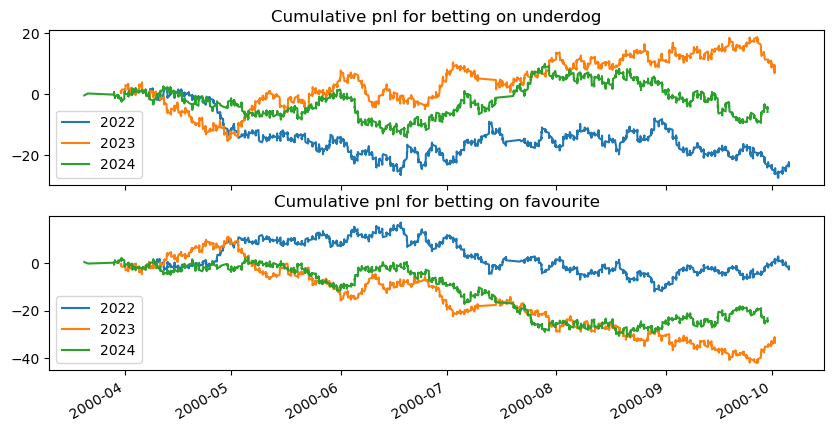

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
ax[0].set_title("Cumulative pnl for betting on underdog")
get_year_pnl_graph(ax[0], underdog_df, "underdog_pnl")
ax[1].set_title("Cumulative pnl for betting on favourite")
get_year_pnl_graph(ax[1], underdog_df, "favourite_pnl")
plt.gcf().autofmt_xdate()
plt.show()

It looks like betting on the underdog is marginally better than betting on the favourite, but that isn't very statistically significant. Before going on, I want to note that PNL for each trade is very much non-normally distributed!!! Have a look at this:

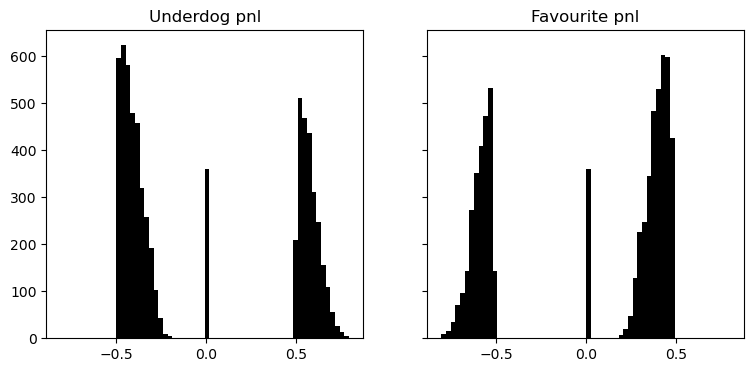

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharex=True, sharey=True)
ax[0].set_title("Underdog pnl")
ax[0].hist(underdog_df["underdog_pnl"], bins=50, color="black")
ax[1].set_title("Favourite pnl")
ax[1].hist(underdog_df["favourite_pnl"], bins=50, color="black")
plt.show()

These are some funny shaped plots. The spike at 0 is for games where the teams are judged by the market to be equal matches. By definition, an underdog can't lose more than 50c, and must pay off more than 50c (this is approximate, given spreads). The left bump for underdog pnl is larger than the right bump because, unsurprisingly, underdogs tend to lose. And everything is reversed for favourite pnl, as it should be. 

The funniness of the plots' shape says something important: these payoffs are very much NOT normal, so to be safe I'm going to test for statistical significance by doing bootstraps rather than doing anything frequentist, the usual tests of which assume normality. (I am aware of the Wilcoxon signed rank test etc., but those sorts of tests are a bit weird and I prefer the good honest bootstrap.) Let's test if the means of these two populations are significantly different:

In [41]:
def get_boot_hist(df, pnl_a, pnl_b, iters=10000):
    diff_df = pd.DataFrame([
        df.sample(frac=1, replace=True)[[pnl_a, pnl_b]].sum() 
        for _ in range(iters)
    ])
    fig, ax = plt.subplots()
    frac = ((diff_df[pnl_a] - diff_df[pnl_b]) > 0).mean()
    ax.set_title(f"Frac {pnl_a} - {pnl_b} > 0: {frac:.3f}")
    ax.hist(diff_df[pnl_a] - diff_df[pnl_b], bins=50, color="black")
    plt.show()

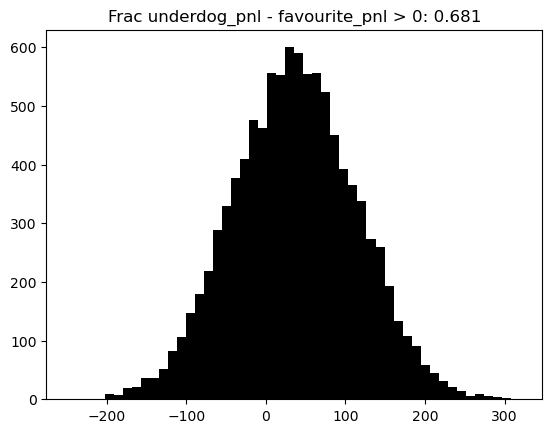

In [42]:
get_boot_hist(underdog_df, "underdog_pnl", "favourite_pnl")

Looks like noise. 

# Baseline B: look at home v away

In [34]:
home_df = df.copy()
home_df["pro_home_pnl"] = home_df["home_win"] - home_df["synth_home_ask"]
home_df["anti_home_pnl"] = home_df["synth_home_bid"] - home_df["home_win"]

In [35]:
def get_year_pnl_graph(ax, df, pnl_column):
    years = [2022, 2023, 2024]
    for year in years:
        year_df = df[df["year"] == year]
        ax.plot(
            list(pd.to_datetime(year_df["date_mod_year"])),
            list(year_df[pnl_column].cumsum())
        )
    ax.legend(years)

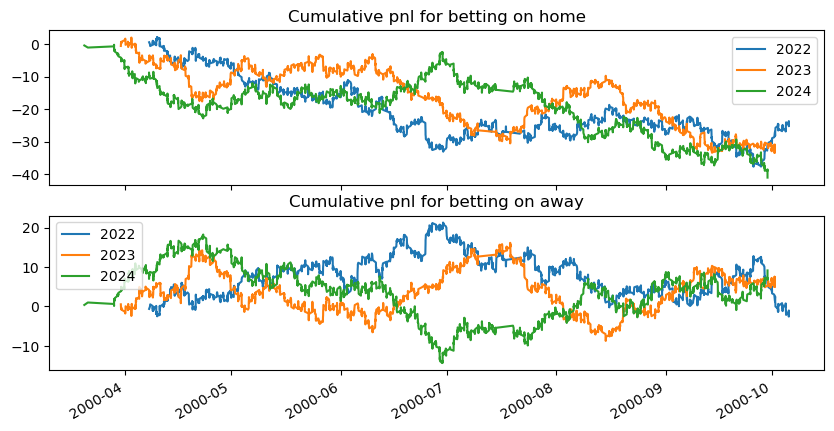

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
ax[0].set_title("Cumulative pnl for betting on home")
get_year_pnl_graph(ax[0], home_df, "pro_home_pnl")
ax[1].set_title("Cumulative pnl for betting on away")
get_year_pnl_graph(ax[1], home_df, "anti_home_pnl")
plt.gcf().autofmt_xdate()
plt.show()

Looks like betting on the home team is a pretty bad idea!

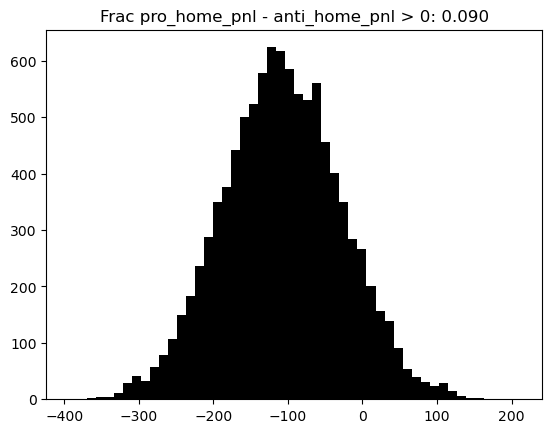

In [43]:
get_boot_hist(home_df, "pro_home_pnl", "anti_home_pnl")

That looks pretty significant, albeit not watertight. Also, it is worth noting that there are decent priors in favour of this inequality: home fans are probably paying more attention, and so are betting more. This would mean that the home team is generally overpriced. 

# Baseline C: look at small v large market

In [208]:
mkt_df = df.copy()

In [209]:
mkt_df["pro_home_pnl"] = mkt_df["home_win"] - mkt_df["synth_home_ask"]
mkt_df["anti_home_pnl"] = mkt_df["synth_home_bid"] - mkt_df["home_win"]

market_info = pd.read_csv("refined_csvs/large_market.csv")
market_dict = dict(zip(market_info["full_name"], market_info["pop"]))
mkt_df["home_mkt_size"] = mkt_df["home"].map(market_dict)
mkt_df["away_mkt_size"] = mkt_df["away"].map(market_dict)

In [210]:
mkt_df["large_mkt_pnl"] = np.where(
    mkt_df["home_mkt_size"] < mkt_df["away_mkt_size"],
    mkt_df["synth_home_bid"] - mkt_df["home_win"],
    0 # Home smaller market, bet on away
) + np.where(
    mkt_df["home_mkt_size"] > mkt_df["away_mkt_size"],
    mkt_df["home_win"] - mkt_df["synth_home_ask"],
    0 # Home larger market, bet on home
) 
mkt_df["small_mkt_pnl"] = np.where(
    mkt_df["home_mkt_size"] < mkt_df["away_mkt_size"],
    mkt_df["home_win"] - mkt_df["synth_home_ask"],
    0 # Home smaller market, bet on home
) + np.where(
    mkt_df["home_mkt_size"] > mkt_df["away_mkt_size"],
    mkt_df["synth_home_bid"] - mkt_df["home_win"],
    0 # Home larger market, bet on away
) 

In [205]:
def get_year_pnl_graph(ax, df, pnl_column):
    years = [2022, 2023, 2024]
    for year in years:
        year_df = df[df["year"] == year]
        ax.plot(
            list(pd.to_datetime(year_df["date_mod_year"])),
            list(year_df[pnl_column].cumsum())
        )
    ax.legend(years)

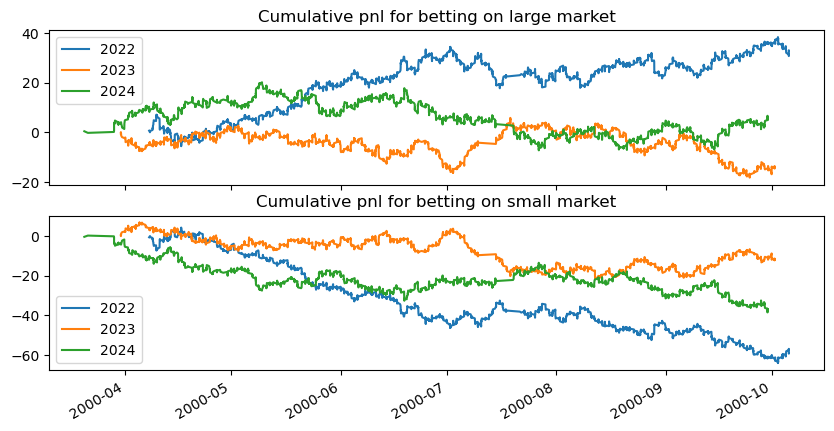

In [211]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
ax[0].set_title("Cumulative pnl for betting on large market")
get_year_pnl_graph(ax[0], mkt_df, "large_mkt_pnl")
ax[1].set_title("Cumulative pnl for betting on small market")
get_year_pnl_graph(ax[1], mkt_df, "small_mkt_pnl")
plt.gcf().autofmt_xdate()
plt.show()

# The cLI arb

In [44]:
cli_df = df.dropna(subset=["home_cli", "away_cli"]).copy()

In [45]:
cli_df["min_cli"] = cli_df[["home_cli", "away_cli"]].min(axis=1)
cli_df["max_cli"] = cli_df[["home_cli", "away_cli"]].max(axis=1)
cli_df["home_excess_cli"] = cli_df["home_cli"] - cli_df["away_cli"]

Let's put some priors out there:
* Teams might overperform when they have high CLI, because they play harder or smth
* OR crowd goes for them harder and home advantage is larger
* Equally, maybe pressure gets to them and they don't perform well
* This could be extra large in cases where there isn't much on the line for the other team

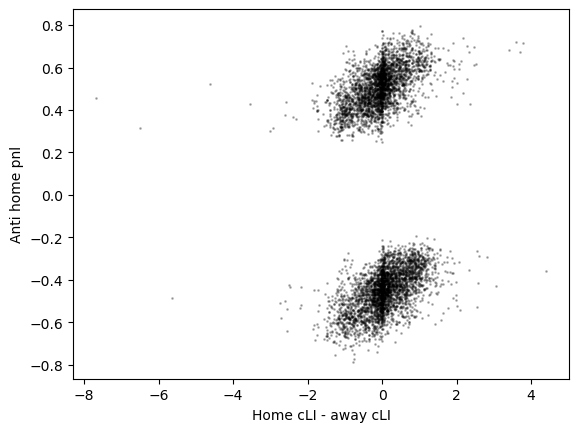

In [47]:
fig, ax = plt.subplots()
ax.scatter(cli_df["home_excess_cli"], cli_df["anti_home_pnl"], s=1, color="black", alpha=0.25)
ax.set_xlabel("Home cLI - away cLI")
ax.set_ylabel("Anti home pnl")
plt.show()

Hmmm, this is a curious plot. Note the top blob is the cases where the away team wins and the left blob is when the home team wins. There is a pretty clear positive trend in each blob, which suggests that if the home team has excess cLI, the market has a higher implied probability on the home team winning. 

This doesn't yet look like an arb because we could still get Simpson's Paradoxed, where the trend in each subpopulation doesn't translate into a trend in the population, presumably because when the home team has excess cLI they actually win more. This could be plausible, because you only really get cLI differences when one team is on the cusp of making it to playoffs and the other one isn't. Most teams that aren't on said cusp are teams that have no chance of making playoffs, so ehh maybe high cLI diff means the high cLI team is just the better team. Let's see. 

In [48]:
cli_df["home_excess_cli"].corr(cli_df["anti_home_pnl"])

np.float64(0.006132885661578427)

So there is positive correlation, but not much. Corr is a pretty bad tool to use here, (a) because there are a few super high leverage points (looking at you, point on the left with cli diff -7.69, which is Astros @ Diamondbacks 2023-09-30: the Diamondbacks had already qualified for playoffs and the Astros qualified iff they won the game) which really distort things, and (b) the joint distribution is clearly not multivariate normal. But it still gives some clue. 

But looking at those blobs, something is up. Surely there are often teams on the cusp of qualifying for playoffs who are against teams that finished top of division? In those cases, the top of division team would probably have a better chance of winning, but nothing corresponding to that expectation appears on the scatter plot. So I don't think this is about the smart money evaluating which teams are likelier to win, it is about a large mismatch of demand. To illustrate, in the World Series, fans of both teams (and neutrals too, I suppose) are betting on each team more than they would for a regular season game - the game matters more to them, more people are paying attention, and so on. In the extreme, cLI mismatches are cases where a game is the World Series, but only for one team. So that team brings excess demand, while the other team brings maybe even less than usual. This mismatch boosts the high cLI team's implied win probability beyond what it should be. Then there could be money to be made taking the other side of that trade! 

This isn't foolproof. Other people could have cottoned on to this strategy. Or in high-stakes situations, the high-cLI team gives it everything and performs well while the low-cLI team doesn't try so hard. Similarly, low-cLI teams don't field their best pitchers while the high-cLI teams do. So let's run the numbers:

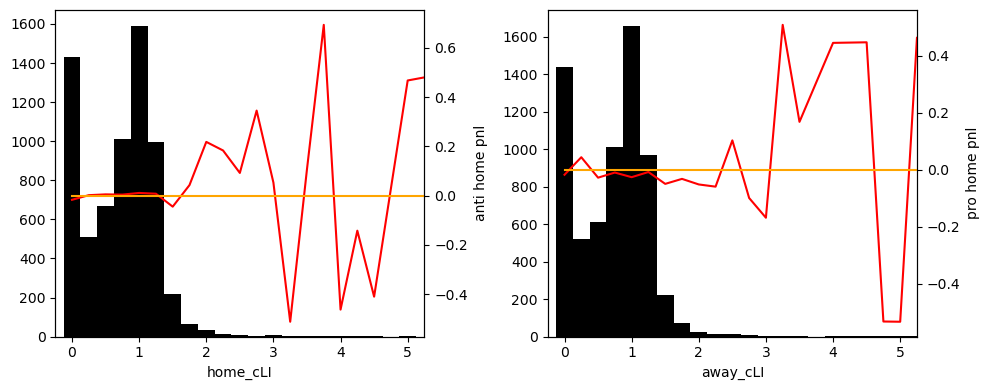

In [64]:
def get_cli_bucket_pnl_chart(ax, df, side, direction):
    rounder = 0.25
    df[f"{side}_cli_bin"] = np.round(df[f"{side}_cli"] / rounder, decimals=0) * rounder
    ax.hist(
        df[f"{side}_cli_bin"], 
        bins=np.arange(0 - rounder / 2, 7 + rounder / 2, rounder), 
        color="black"
    )
    twin_ax = ax.twinx()
    twin_ax.plot(df.groupby(f"{side}_cli_bin")[f"{direction}_home_pnl"].mean(), color="red")
    twin_ax.plot([0, 7], [0, 0], color="orange")
    ax.set_xlabel(f"{side}_cLI")
    twin_ax.set_ylabel(f"{direction} home pnl")
    ax.set_xlim(-0.25, 5.25)
    # return ax


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
get_cli_bucket_pnl_chart(ax[0], cli_df, "home", "anti")
get_cli_bucket_pnl_chart(ax[1], cli_df, "away", "pro")
plt.tight_layout()
plt.show()

The right region of the graph is quite noisy and hence not really worth looking at, really everything beyond 3. The histogram shows that the sample size is very small so the red line which shows betting pnl will shoot all over the place at the slightest provocation. 

The interesting place is where there is a decent sample size but still somewhat extreme values, in roughly the 2-3 cLI region. In the home case, this region is very good for betting against the home team. In the away case, not so much, but it does look to be the time when, if you had to bet on a home team, that would be the time to do it. 

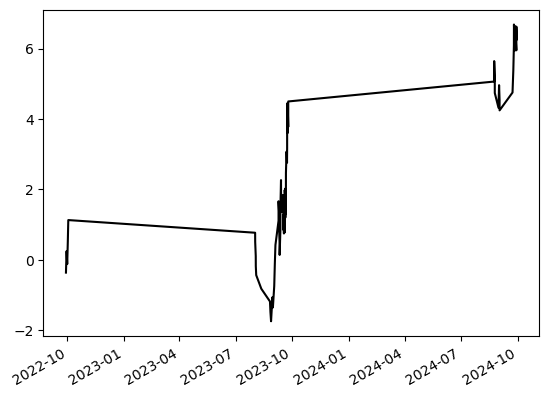

In [68]:
# Try the "bet against home team if big cLI differential" strat
anti_home_cli_trim = cli_df[(cli_df["home_cli"] > 1.5) & (cli_df["away_cli"] < 0.5)]
fig, ax = plt.subplots()
ax.plot(anti_home_cli_trim["game_time"], anti_home_cli_trim["anti_home_pnl"].cumsum(), color="black")
plt.gcf().autofmt_xdate()
plt.show()

Not your average looking PNL plot. The reason is that the big cLI differentials only come about at the end of the season. See here: 

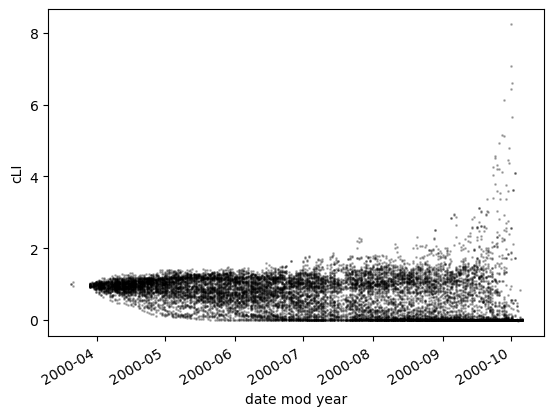

In [70]:
fig, ax = plt.subplots()
for team in ["home", "away"]:
    ax.scatter(cli_df["date_mod_year"], cli_df[f"{team}_cli"], s=1, color="black", alpha=0.25)
ax.set_ylabel("cLI")
ax.set_xlabel("date mod year")
plt.gcf().autofmt_xdate()
plt.show()

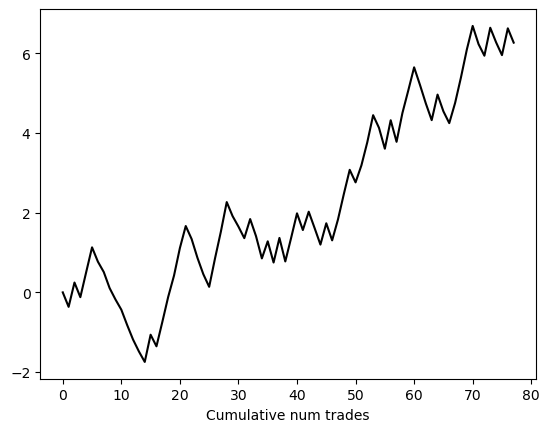

In [216]:
# Now smoothing it out
anti_home_cli_trim = cli_df[(cli_df["home_cli"] > 1.5) & (cli_df["away_cli"] < 0.5)]
fig, ax = plt.subplots()
ax.plot(
    range(len(anti_home_cli_trim) + 1), 
    [i for i in [0] + list(anti_home_cli_trim["anti_home_pnl"].cumsum())], # start at 0
    color="black"
)
ax.set_xlabel("Cumulative num trades")
plt.show()

Looks pretty healthy! To test the hypothesis, let's see how it goes on the other leg of the trade, i.e., betting against the away team when they have excess cLI:

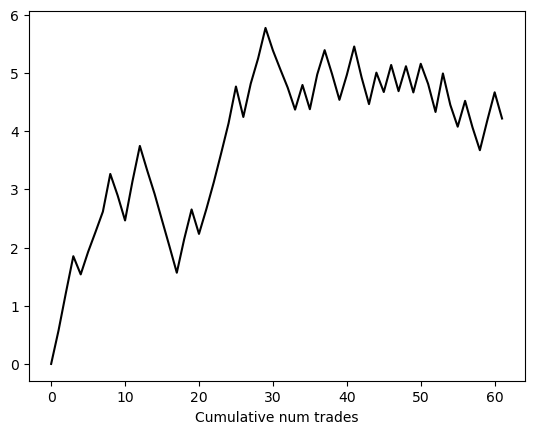

In [217]:
# Now smoothing it out
pro_home_cli_trim = cli_df[(cli_df["home_cli"] < 0.5) & (cli_df["away_cli"] > 1.5)]
fig, ax = plt.subplots()
ax.plot(
    range(len(pro_home_cli_trim) + 1), 
    [i for i in [0] + list(pro_home_cli_trim["pro_home_pnl"].cumsum())], 
    color="black"
)
ax.set_xlabel("Cumulative num trades")
plt.show()

Somewhat less exciting, but still a good sign that the line generally trends up. Remember, betting on the away team is usually a bad idea, so the mere fact that this doesn't lose money confirms the idea behind the strat. 

Do some bootstraps to test for significance:

In [79]:
def single_col_boot_hist(column, ax, iters=10000):
    boots = pd.Series([column.sample(frac=1, replace=True).mean() for _ in range(iters)])
    ax.hist(boots, bins=50, color="black")
    ax.set_title(f"Frac > 0: {(boots > 0).mean():.3f}")

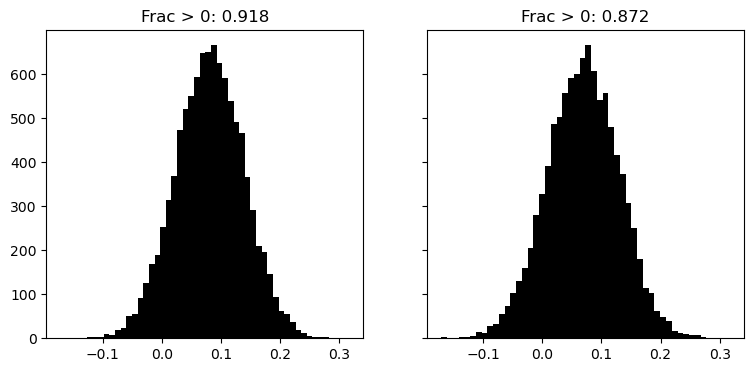

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharex=True, sharey=True)
single_col_boot_hist(anti_home_cli_trim["anti_home_pnl"], ax[0])
single_col_boot_hist(pro_home_cli_trim["pro_home_pnl"], ax[1])
plt.show()

Left is the anti-home variant, right is the pro-home variant. And pooling them:

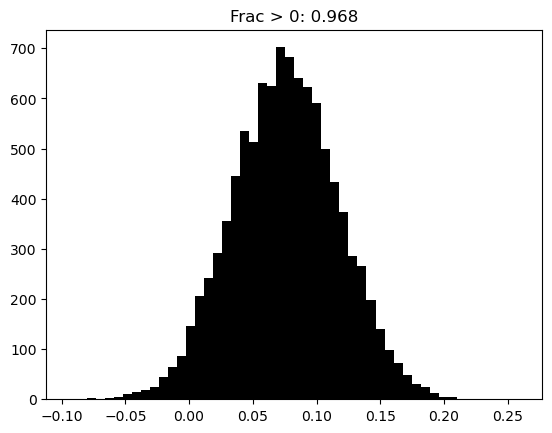

In [83]:
fig, ax = plt.subplots()
pnls = pd.concat([anti_home_cli_trim["anti_home_pnl"], pro_home_cli_trim["pro_home_pnl"]])
single_col_boot_hist(pnls, ax)
plt.show()

In [94]:
def get_sharpe(s): return s.sum() / (s ** 2).sum() ** 0.5

print(get_sharpe(anti_home_cli_trim["anti_home_pnl"]), len(anti_home_cli_trim["anti_home_pnl"]))
print(get_sharpe(pro_home_cli_trim["pro_home_pnl"]), len(pro_home_cli_trim["pro_home_pnl"]))
print(get_sharpe(pnls), len(pnls))

1.4067399187888747 77
1.1320488876521166 61
1.805340603017353 138


And there are the sharpes, pretty decent given how few trades there are in the dataset!! Note that while this does include spread crossing costs, it doesn't include fees, so we can add those in:

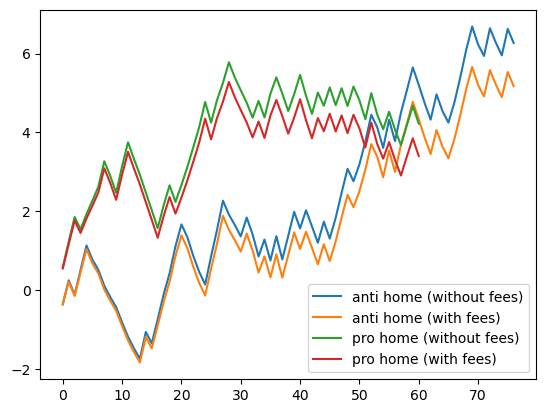

In [90]:
def add_fees(s): return np.where(s > 0, s * 0.95, s)

fig, ax = plt.subplots()
for pnl in [anti_home_cli_trim["anti_home_pnl"], pro_home_cli_trim["pro_home_pnl"]]:
    ax.plot(range(len(pnl)), pnl.cumsum())
    ax.plot(range(len(pnl)), add_fees(pnl).cumsum())
ax.legend([
    f"{direc} home ({pm} fees)" 
    for direc in ["anti", "pro"] for pm in ["without", "with"]
])
plt.show()

It's not like the strat is now at significantly increased risk of losing money. That's because the edge is huge:

In [89]:
for pnl in [anti_home_cli_trim["anti_home_pnl"], pro_home_cli_trim["pro_home_pnl"]]:
    print(pnl.sum() / len(pnl))

0.08137790237618144
0.06917393453640001


What this means is that anti-home bets average 8c of expectancy, and pro-home bets average 7c of expectancy. This is quite a lot, given usually you stand to gain or lose only 50c!! (The bet I'm doing is to purchase a single contract, i.e., you pay x cents to get $1 if you win.) Hence the fees of 5% of winnings, while significant, don't send it underwater. 

Let's try optimising those parameters, because it would be surprising if the numbers I chose looking at the graph were the best ones. 

In [237]:
# Get a grid, for anti and pro
def grid_search(und_1_grid, ove_1_grid, df, direction):
    first_side = {"anti": "away", "pro": "home"}[direction] # team you're betting for
    second_side = {"anti": "home", "pro": "away"}[direction] # team you're betting against
    search_df = pd.DataFrame(0.0, columns=ove_1_grid, index=und_1_grid)
    for und in und_1_grid:
        for ove in ove_1_grid:
            cli_trim = df[
                (df[f"{first_side}_cli"] < und / 1000) # team for has low cli
                & (df[f"{second_side}_cli"] > ove / 1000) # team against has high cli
            ]
            pnls = cli_trim[f"{direction}_home_pnl"]
            sharpe = get_sharpe(add_fees(pnls)) if len(pnls) > 0 else 0.0
            search_df.loc[und, ove] = sharpe
    return search_df

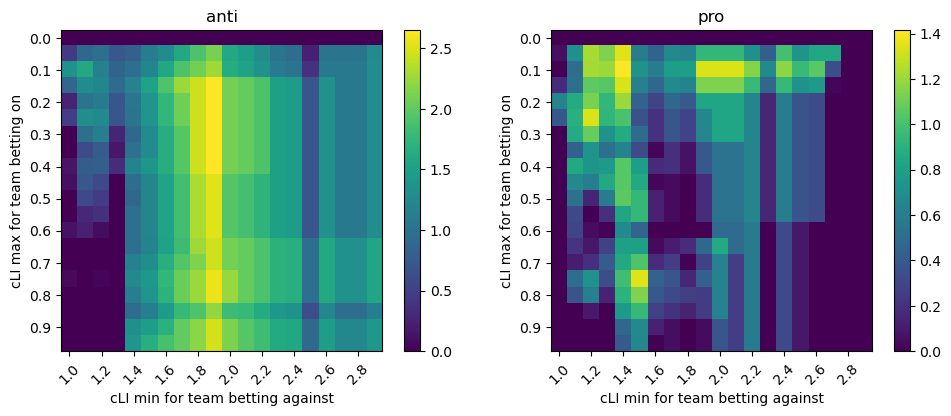

In [238]:
# Doing everything in ints to avoid floating point nonsense with df.loc[]
und_1_grid = pd.Series(range(0, 1000, 50))
ove_1_grid = pd.Series(range(1000, 3000, 100))
cut = int(len(und_1_grid) / 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, direc in zip([0, 1], ["anti", "pro"]):
    search_df = grid_search(und_1_grid, ove_1_grid, cli_df, direc)
    im = ax[i].imshow(search_df, vmin=0)
    plt.colorbar(im)
    ax[i].set_xticks(list(range(len(ove_1_grid)))[::cut], (ove_1_grid / 1000).iloc[::cut], rotation=45)
    ax[i].set_yticks(list(range(len(und_1_grid)))[::cut], (und_1_grid / 1000).iloc[::cut])
    ax[i].set_xlabel("cLI min for team betting against")
    ax[i].set_ylabel("cLI max for team betting on")
    ax[i].set_title(direc)
plt.tight_layout()
plt.show()

Hmmm - what to make of this? The "anti" plot seems fine and nice and smooth, but the "pro" plot doesn't have much structure at all. I guess generally you want the cLI min to be lower, which is useful information? And at least in those cases you're getting more bets, so it's not like it's shrinking the dataset until it gets some big Sharpes. 

In [170]:
def grid_counts(und_1_grid, ove_1_grid, df, direction):
    first_side = {"anti": "away", "pro": "home"}[direction] # team you're betting for
    second_side = {"anti": "home", "pro": "away"}[direction] # team you're betting against
    search_df = pd.DataFrame(0.0, columns=ove_1_grid, index=und_1_grid)
    for und in und_1_grid:
        for ove in ove_1_grid:
            search_df.loc[und, ove] = len(df[
                (df[f"{first_side}_cli"] < und / 1000) # team for has low cli
                & (df[f"{second_side}_cli"] > ove / 1000) # team against has high cli
            ])
    return search_df

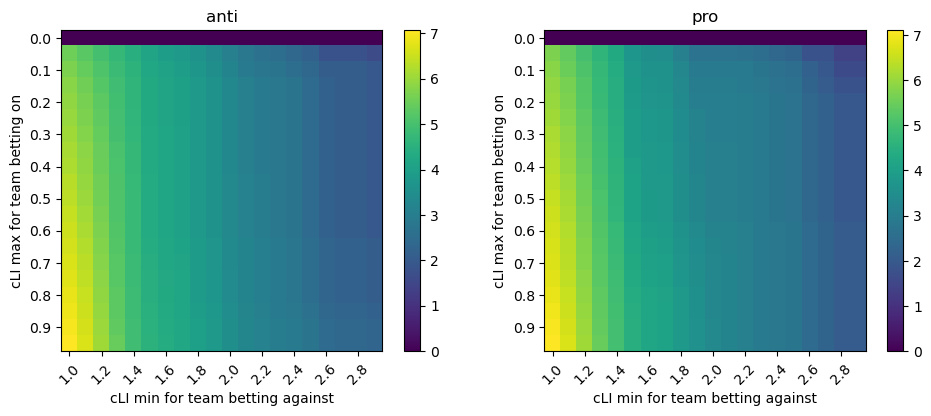

In [173]:
# Doing everything in ints to avoid floating point nonsense with df.loc[]
und_1_grid = pd.Series(range(0, 1000, 50))
ove_1_grid = pd.Series(range(1000, 3000, 100))
cut = int(len(und_1_grid) / 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, direc in zip([0, 1], ["anti", "pro"]):
    search_df = grid_counts(und_1_grid, ove_1_grid, cli_df, direc)
    im = ax[i].imshow(np.log(search_df + 1), vmin=0)
    plt.colorbar(im)
    ax[i].set_xticks(list(range(len(ove_1_grid)))[::cut], (ove_1_grid / 1000).iloc[::cut], rotation=45)
    ax[i].set_yticks(list(range(len(und_1_grid)))[::cut], (und_1_grid / 1000).iloc[::cut])
    ax[i].set_xlabel("cLI min for team betting against")
    ax[i].set_ylabel("cLI max for team betting on")
    ax[i].set_title(direc)
plt.tight_layout()
plt.show()

So really want hotspots that have decent sample sizes. This looks like for "anti" doing (0.5, 1.8), and for "pro" doing (0.7, 1.5). 

In [245]:
anti_home_cli_trim = cli_df[(cli_df["home_cli"] > 1.8) & (cli_df["away_cli"] < 0.5)]
pro_home_cli_trim = cli_df[(cli_df["home_cli"] < 0.2) & (cli_df["away_cli"] > 1.2)]

2.326525399839655 45
1.1325953298039588 187


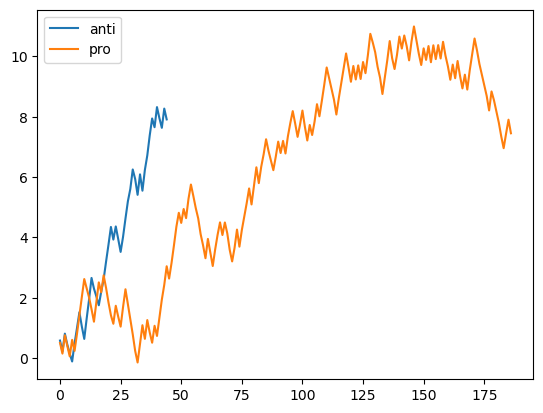

In [246]:
fig, ax = plt.subplots()
for pnl in [anti_home_cli_trim["anti_home_pnl"], pro_home_cli_trim["pro_home_pnl"]]:
    post_fees = add_fees(pnl)
    print(get_sharpe(post_fees), len(post_fees))
    ax.plot(range(len(post_fees)), post_fees.cumsum())
ax.legend(["anti", "pro"])
plt.show()

In [250]:
get_sharpe(add_fees(pd.concat([
    anti_home_cli_trim["anti_home_pnl"], 
    pro_home_cli_trim["pro_home_pnl"]
])))

np.float64(2.0743621635158678)

NOTE: This is almost certainly an overfit. For "anti", there seems to be a pretty good and large region in the middle of the plot, though, which suggests that there isn't a criminal overfit here. Specifically, the utility function has a pretty wide maximum, which means things aren't so sensitive and really any parameters in a general ballpark (no pun intended) will perform similarly. For "pro", on the other hand, the utility function is much bumpier which means the danger of overfit is a lot worse. I suspect that this is because betting on the home team generally is a bit more dangerous. 

In [247]:
print(add_fees(anti_home_cli_trim["anti_home_pnl"].mean()))
print(add_fees(pro_home_cli_trim["pro_home_pnl"].mean()))

0.18362944527051286
0.050637742170352704


Also, what on earth is up with this? Each trade on the anti variant nets about 20 cents, which is extraordinary given the average loss is 37c, and the maximum loss is 54c. In prod this must be assumed to deliver worse results. Also, let's just see what gets the most MONEY

In [188]:
# Get a grid, for anti and pro
def grid_search_pnl(und_1_grid, ove_1_grid, df, direction):
    first_side = {"anti": "away", "pro": "home"}[direction] # team you're betting for
    second_side = {"anti": "home", "pro": "away"}[direction] # team you're betting against
    search_df = pd.DataFrame(0.0, columns=ove_1_grid, index=und_1_grid)
    for und in und_1_grid:
        for ove in ove_1_grid:
            cli_trim = df[
                (df[f"{first_side}_cli"] < und / 1000) # team for has low cli
                & (df[f"{second_side}_cli"] > ove / 1000) # team against has high cli
            ]
            pnls = cli_trim[f"{direction}_home_pnl"]
            search_df.loc[und, ove] = pnls.sum()
    return search_df

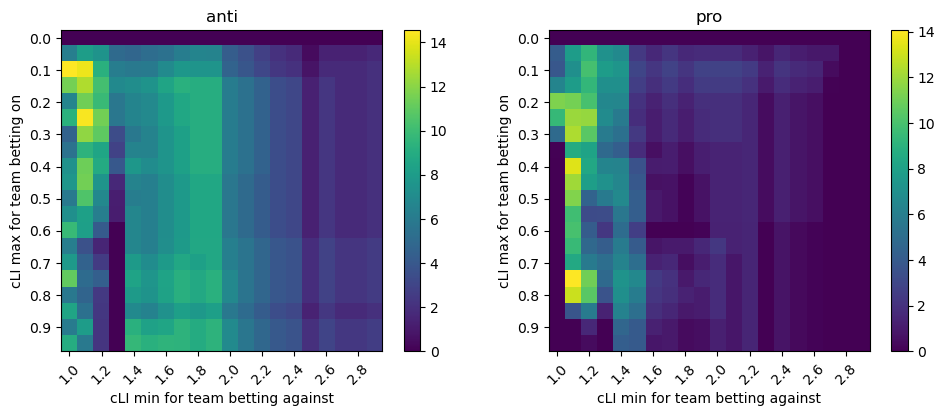

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, direc in zip([0, 1], ["anti", "pro"]):
    search_df = grid_search_pnl(und_1_grid, ove_1_grid, cli_df, direc)
    im = ax[i].imshow(search_df, vmin=0)
    plt.colorbar(im)
    ax[i].set_xticks(list(range(len(ove_1_grid)))[::cut], (ove_1_grid / 1000).iloc[::cut], rotation=45)
    ax[i].set_yticks(list(range(len(und_1_grid)))[::cut], (und_1_grid / 1000).iloc[::cut])
    ax[i].set_xlabel("cLI min for team betting against")
    ax[i].set_ylabel("cLI max for team betting on")
    ax[i].set_title(direc)
plt.tight_layout()
plt.show()

Hmmm more to think about here